## Prerequisites
- Run in python console
#import nltk; nltk.download('stopwords')

- Run in terminal or command prompt
#python3 -m spacy download en

- Go to the MALLET Mdownload page and download the latest version of MALLET. At the time of writing, the latest version is 2.0.8.
#http://mallet.cs.umass.edu/download.php

In [2]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import nltk
#nltk.download('stopwords')
from nltk import FreqDist
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [3]:
df = pd.read_csv('npr.csv', error_bad_lines=False);

In [4]:
print(len(df))

11992


In [5]:
df["Article"][0]

'In the Washington of 2016, even when the policy can be bipartisan, the politics cannot. And in that sense, this year shows little sign of ending on Dec. 31. When President Obama moved to sanction Russia over its alleged interference in the U. S. election just concluded, some Republicans who had long called for similar or more severe measures could scarcely bring themselves to approve. House Speaker Paul Ryan called the Obama measures ”appropriate” but also ”overdue” and ”a prime example of this administration’s ineffective foreign policy that has left America weaker in the eyes of the world.” Other GOP leaders sounded much the same theme. ”[We have] been urging President Obama for years to take strong action to deter Russia’s worldwide aggression, including its   operations,” wrote Rep. Devin Nunes,  . chairman of the House Intelligence Committee. ”Now with just a few weeks left in office, the president has suddenly decided that some stronger measures are indeed warranted.” Appearing 

## Data Preprocessing

Data preprocessing and cleaning is a very important step in any text mining task,here we perform the following text preprocessing:
- Remove special characters, newline characters and punctuations
- Tokenizing words and create Bigrams and Trigrams 
- Remove stopwords and Lemmatize

### Most common words in the articles

In [6]:
import seaborn as sns
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([str(text) for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

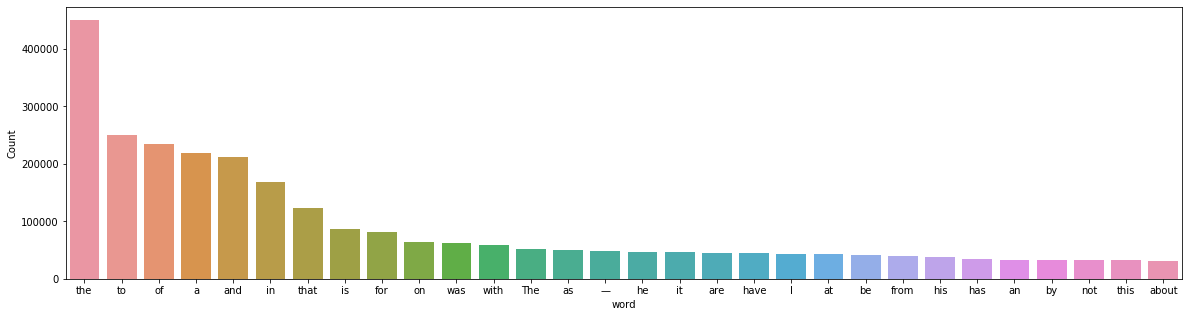

In [7]:
freq_words(df['Article'])

Most common words are 'the','to','of' and so on.These words are not very important for our task as they do not convey special meaning about any of the documents.Therefore we will to remove these kind of words from our documents.

In [9]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df['Article'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['in', 'the', 'washington', 'of', 'even', 'when', 'the', 'policy', 'can', 'be', 'bipartisan', 'the', 'politics', 'cannot', 'and', 'in', 'that', 'sense', 'this', 'year', 'shows', 'little', 'sign', 'of', 'ending', 'on', 'dec', 'when', 'president', 'obama', 'moved', 'to', 'sanction', 'russia', 'over', 'its', 'alleged', 'interference', 'in', 'the', 'election', 'just', 'concluded', 'some', 'republicans', 'who', 'had', 'long', 'called', 'for', 'similar', 'or', 'more', 'severe', 'measures', 'could', 'scarcely', 'bring', 'themselves', 'to', 'approve', 'house', 'speaker', 'paul', 'ryan', 'called', 'the', 'obama', 'measures', 'appropriate', 'but', 'also', 'overdue', 'and', 'prime', 'example', 'of', 'this', 'administration', 'ineffective', 'foreign', 'policy', 'that', 'has', 'left', 'america', 'weaker', 'in', 'the', 'eyes', 'of', 'the', 'world', 'other', 'gop', 'leaders', 'sounded', 'much', 'the', 'same', 'theme', 'we', 'have', 'been', 'urging', 'president', 'obama', 'for', 'years', 'to', 'take'

- Bigrams are two words that frequently occur together in the document, Similarily Trigrams are 3 words that frequently occur in the document.

- Some examples from our document: fox_news, private_server, russian_president_vladimir.

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



In [11]:
# See trigram example
print(trigram_mod[trigram_mod[data_words[0]]])

['in', 'the', 'washington', 'of', 'even', 'when', 'the', 'policy', 'can', 'be', 'bipartisan', 'the', 'politics', 'cannot', 'and', 'in', 'that', 'sense', 'this', 'year', 'shows', 'little', 'sign', 'of', 'ending', 'on', 'dec', 'when', 'president', 'obama', 'moved', 'to', 'sanction', 'russia', 'over', 'its', 'alleged', 'interference', 'in', 'the', 'election', 'just', 'concluded', 'some', 'republicans', 'who', 'had', 'long', 'called', 'for', 'similar', 'or', 'more', 'severe', 'measures', 'could', 'scarcely', 'bring', 'themselves', 'to', 'approve', 'house_speaker_paul_ryan', 'called', 'the', 'obama', 'measures', 'appropriate', 'but', 'also', 'overdue', 'and', 'prime', 'example', 'of', 'this', 'administration', 'ineffective', 'foreign_policy', 'that', 'has', 'left', 'america', 'weaker', 'in', 'the', 'eyes', 'of', 'the', 'world', 'other', 'gop', 'leaders', 'sounded', 'much', 'the', 'same', 'theme', 'we', 'have', 'been', 'urging', 'president', 'obama', 'for', 'years', 'to', 'take', 'strong', '

In [12]:
# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text )

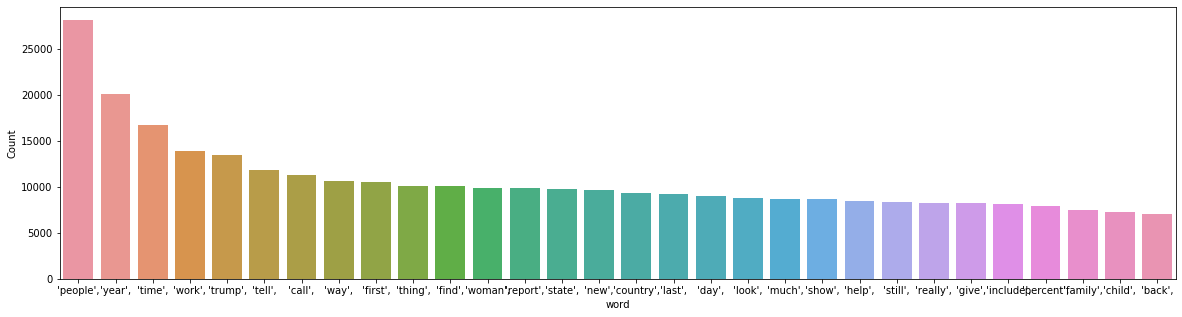

In [13]:
freq_words(data_ready)

- Now the most frequent terms in our data seems to be relevant.We can now start building our topic model.

- Word clouds are a great way to visualize the most prominent words in a document.

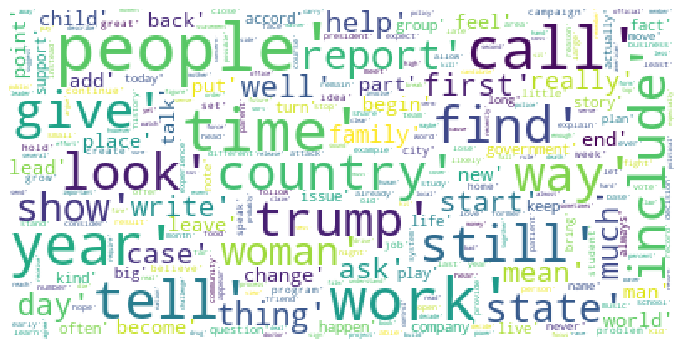

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data_ready))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

- First, we are creating a dictionary from the data, then convert to bag-of-words corpus.
- Gensim creates a unique id for each word in the document.The corpus shown below is a mapping of (word_id, word_frequency).

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus
texts = data_ready

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 2), (15, 1), (16, 1), (17, 2), (18, 1), (19, 3), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 7), (39, 4), (40, 1), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 3), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 2), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 4), (91, 1), (92, 1), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 3), (105, 2), (106, 1), (107, 1), (108, 1), (109, 1), (110, 3)

In [16]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('accept', 1),
  ('act', 1),
  ('action', 4),
  ('actual', 1),
  ('add', 1),
  ('administration', 1),
  ('affair', 1),
  ('afloat', 1),
  ('aggression', 1),
  ('ago', 1),
  ('agree', 2),
  ('aleppo', 1),
  ('allege', 2),
  ('allow', 2),
  ('always', 1),
  ('american', 1),
  ('amount', 2),
  ('annexation', 1),
  ('appear', 3),
  ('appropriate', 1),
  ('approve', 1),
  ('arise', 1),
  ('assessment', 1),
  ('available', 1),
  ('back', 1),
  ('battle', 1),
  ('believe', 1),
  ('besiege', 1),
  ('big', 1),
  ('bipartisan', 1),
  ('bombing', 1),
  ('box', 1),
  ('briefing', 2),
  ('bring', 1),
  ('bromance', 1),
  ('bully', 1),
  ('cajoled', 1),
  ('call', 7),
  ('campaign', 4),
  ('center', 1),
  ('chairman', 2),
  ('child', 1),
  ('choose', 1),
  ('chorus', 1),
  ('city', 1),
  ('close', 2),
  ('colleague', 1),
  ('commitment', 1),
  ('committee', 1),
  ('commodity', 1),
  ('compound', 1),
  ('compromise', 1),
  ('computer', 3),
  ('concern', 2),
  ('conclude', 1),
  ('

## Building the topic model

A lot of parameters can be tuned to optimize training for our specific case.
- <b>num_topics</b> is the number of requested latent topics to be extracted from the training corpus, 
- <b>update_every</b> specifies Number of documents to be iterated through for each update.
- <b>passes</b> is the total number of training passes.
- <b>alpha</b> and <b>eta</b> are set to 'auto' to learn the asymmetric prior from the data,for more information https://datascience.stackexchange.com/questions/199/what-does-the-alpha-and-beta-hyperparameters-contribute-to-in-latent-dirichlet-a.

In [17]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

- We print the keywords for each topic and the weightage of each keyword in that particular topic

In [18]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.070*"percent" + 0.030*"year" + 0.026*"job" + 0.022*"country" + '
  '0.019*"number" + 0.017*"rate" + 0.016*"worker" + 0.015*"increase" + '
  '0.013*"high" + 0.013*"economy"'),
 (1,
  '0.039*"pay" + 0.029*"plan" + 0.029*"money" + 0.028*"cost" + 0.027*"health" '
  '+ 0.026*"insurance" + 0.026*"program" + 0.023*"coverage" + 0.021*"people" + '
  '0.020*"state"'),
 (2,
  '0.018*"write" + 0.013*"music" + 0.012*"love" + 0.012*"book" + 0.010*"story" '
  '+ 0.009*"song" + 0.008*"world" + 0.008*"new" + 0.008*"name" + '
  '0.008*"record"'),
 (3,
  '0.119*"school" + 0.104*"student" + 0.038*"teacher" + 0.037*"education" + '
  '0.028*"program" + 0.024*"child" + 0.023*"kid" + 0.020*"learn" + '
  '0.018*"college" + 0.017*"teach"'),
 (4,
  '0.029*"police" + 0.029*"report" + 0.026*"kill" + 0.024*"attack" + '
  '0.016*"officer" + 0.015*"tell" + 0.015*"man" + 0.014*"military" + '
  '0.012*"shoot" + 0.011*"people"'),
 (5,
  '0.113*"trump" + 0.041*"election" + 0.039*"vote" + 0.037*"campaign" + '
  

- Topic 0 includes words like “percent”, “year”, “job” and “country”, sounds like a topic related to jobs. Topic 1 includes words like “pay”, “plan”, “money” and “cost”, it is definite a graphic money related topic. Topic 2 includes words like “write”, “music”, “love” and “book”, sounds like a hobby related topic. And so on.

- Perplexity is measured as the normalized log-likelihood of the held out test set.However, studies have shown that Perplexity is not strongly correlated to human judgment and, even sometimes slightly anti-correlated.
- Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.For more information about Topic Coherence check http://qpleple.com/topic-coherence-to-evaluate-topic-models/.

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.177613656368148

Coherence Score:  0.5386930570305681


## pyLDAvis

pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to provide an interactive web-based visualization.

In [20]:
# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.177601  0.086426       1        1  22.421902
8      0.179556  0.006160       2        1  11.623743
14     0.148637  0.065532       3        1   9.690784
2      0.081332  0.222835       4        1   8.611218
17     0.117802 -0.091813       5        1   6.677446
19     0.121064 -0.117035       6        1   5.161983
5      0.102298  0.069652       7        1   5.110883
4      0.061512  0.081944       8        1   4.493208
15    -0.007723  0.134780       9        1   3.832324
16     0.072167 -0.031640      10        1   3.750555
0      0.120191 -0.135720      11        1   3.658899
6      0.082034 -0.169169      12        1   3.606242
1      0.053629 -0.242454      13        1   2.553533
12    -0.097275  0.154175      14        1   2.238277
10    -0.112894  0.223504      15        1   2.167463
11    -0.041715 -0.006396      16        1   1.755613
3     -0.078099 -0.110378      17        1   1.582436
9     -0.280990 -0.039753      18        1   0.833558
13    -0.351464 -0.051578      19        1   0.152069
18    -0.347661 -0.049071      20        1   0.077860, topic_info=            Term          Freq         Total Category  logprob  loglift
283        trump  18241.000000  18241.000000  Default  30.0000  30.0000
886        woman  12088.000000  12088.000000  Default  29.0000  29.0000
531       people  33835.000000  33835.000000  Default  28.0000  28.0000
301         year  26743.000000  26743.000000  Default  27.0000  27.0000
752      percent   9230.000000   9230.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
7898        pump      0.027871      1.113921  Topic20 -11.3881   3.4700
6896    bathroom      0.027871      1.113947  Topic20 -11.3881   3.4699
9324     section      0.027871      1.113936  Topic20 -11.3881   3.4699
6333  assistance      0.027871      1.113936  Topic20 -11.3881   3.4699
8897      margin      0.027871      1.113946  Topic20 -11.3881   3.4699

[1207 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3491      6  0.998357    abortion
3587     11  0.981609      abuser
4137     13  0.988001         aca
4425     17  0.998341    academic
5328     19  0.970336  accelerate
...     ...       ...         ...
1342     12  0.007722       young
1342     13  0.003003       young
1342     14  0.134925       young
1342     17  0.052125       young
2081     15  0.994797     youtube

[2829 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 15, 3, 18, 20, 6, 5, 16, 17, 1, 7, 2, 13, 11, 12, 4, 10, 14, 19])

- Now we will look at Mallet (MAchine Learning for LanguagE Toolkit). The difference between Mallet and Gensim’s inbuilt version of LDA is that Gensim uses a Variational Bayes sampling method which is faster but less precise that Mallet’s Gibbs Sampling.

In [21]:
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [22]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(16,
  [('write', 0.018943469201541625),
   ('word', 0.015981424232932494),
   ('question', 0.0126380585327323),
   ('world', 0.010322896948072287),
   ('fact', 0.010057334295714227),
   ('idea', 0.009458116003213989),
   ('science', 0.008375437497446512),
   ('time', 0.008130302741423689),
   ('find', 0.007592368137929156),
   ('point', 0.007442563564804097)]),
 (15,
  [('woman', 0.07255154257993907),
   ('black', 0.03031916467003875),
   ('people', 0.026673469991421894),
   ('man', 0.02617801047120419),
   ('white', 0.017488981571863814),
   ('community', 0.011558257165675748),
   ('group', 0.010456414352057266),
   ('call', 0.008792557754311238),
   ('race', 0.008193569379122667),
   ('history', 0.008178779542698258)]),
 (3,
  [('time', 0.016620959029335993),
   ('year', 0.013762154076290202),
   ('car', 0.011476772209756504),
   ('day', 0.00983129726585224),
   ('space', 0.008310479514667997),
   ('energy', 0.0074794315632011965),
   ('hour', 0.007113770464555805),
   ('travel', 0

### Optimal number of topics for LDA
We plot the coherence score against the number of topics and choose a 'k' gices the highest CV before flattening out.

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=40, step=6)

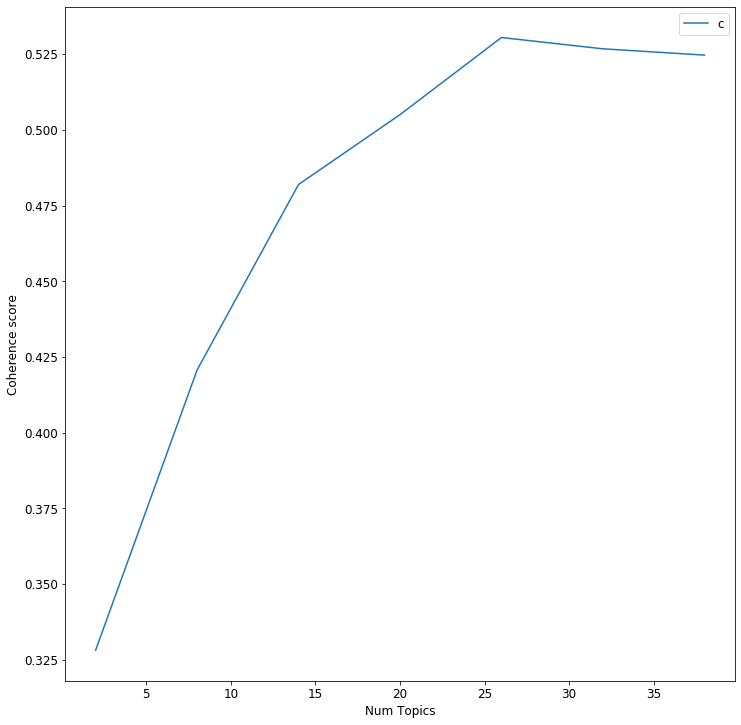

In [25]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3282
Num Topics = 8  has Coherence Value of 0.4207
Num Topics = 14  has Coherence Value of 0.482
Num Topics = 20  has Coherence Value of 0.505
Num Topics = 26  has Coherence Value of 0.5305
Num Topics = 32  has Coherence Value of 0.5267
Num Topics = 38  has Coherence Value of 0.5247


- The above plot shows that coherence score increases with the number of topics, with a decline between 14 to 20.Now, choosing the number of topics still depends on your requirement because topic around 33 have good coherence scores but they run a risk of having repeated keywords in the topic. Topic coherence gives you a good picture so that we can make decisions according to our requirement.

In [27]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.029*"country" + 0.022*"government" + 0.013*"military" + 0.011*"force" + '
  '0.011*"group" + 0.011*"war" + 0.010*"leader" + 0.010*"fight" + '
  '0.008*"refugee" + 0.008*"attack"'),
 (1,
  '0.070*"people" + 0.048*"thing" + 0.025*"talk" + 0.024*"feel" + 0.022*"time" '
  '+ 0.020*"work" + 0.019*"kind" + 0.018*"happen" + 0.014*"start" + '
  '0.011*"person"'),
 (2,
  '0.031*"food" + 0.017*"eat" + 0.010*"grow" + 0.008*"restaurant" + '
  '0.007*"farm" + 0.007*"product" + 0.006*"farmer" + 0.006*"sell" + '
  '0.006*"plant" + 0.006*"drink"'),
 (3,
  '0.020*"report" + 0.013*"information" + 0.011*"call" + 0.010*"statement" + '
  '0.010*"question" + 0.010*"email" + 0.010*"official" + 0.009*"investigation" '
  '+ 0.009*"news" + 0.007*"post"'),
 (4,
  '0.026*"police" + 0.026*"report" + 0.020*"kill" + 0.016*"attack" + '
  '0.015*"people" + 0.013*"officer" + 0.012*"accord" + 0.012*"shoot" + '
  '0.012*"man" + 0.011*"charge"'),
 (5,
  '0.026*"music" + 0.017*"record" + 0.016*"song" + 0.014*"sou

## Dominant topic in each sentence

Our primary goal is to assign a topic to each document,to do that we find the topic number that has the highest percentage contribution in that document.'Dominant_Topic' describes the topic to which that particular document was assigned too and 'Topic_Perc_Contrib' describes the percentage contribution of the topic in the given document.

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.2351,"report, information, call, statement, question...","In the Washington of 2016, even when the polic..."
1,1,19.0,0.2291,"trump, campaign, vote, election, state, voter,...",Donald Trump has used Twitter — his prefe...
2,2,19.0,0.2833,"trump, campaign, vote, election, state, voter,...",Donald Trump is unabashedly praising Russian...
3,3,3.0,0.2088,"report, information, call, statement, question...","Updated at 2:50 p. m. ET, Russian President Vl..."
4,4,14.0,0.0961,"school, student, child, kid, parent, work, pro...","From photography, illustration and video, to d..."
5,5,18.0,0.1857,"study, test, researcher, find, research, peopl...",I did not want to join yoga class. I hated tho...
6,6,18.0,0.3688,"study, test, researcher, find, research, peopl...",With a who has publicly supported the debunk...
7,7,13.0,0.1815,"family, live, life, child, day, home, leave, y...","I was standing by the airport exit, debating w..."
8,8,12.0,0.3278,"animal, human, find, time, year, scientist, sp...","If movies were trying to be more realistic, pe..."
9,9,2.0,0.2377,"food, eat, grow, restaurant, farm, product, fa...","Eighteen years ago, on New Year’s Eve, David F..."


In [30]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5994,"country, government, military, force, group, w...",As President Bashar Assad’s army pushes into t...
1,1.0,0.4963,"people, thing, talk, feel, time, work, kind, h...",Dear Sugar Radio is a weekly podcast from memb...
2,2.0,0.8205,"food, eat, grow, restaurant, farm, product, fa...",If you are turkeyphobic or just bored with t...
3,3.0,0.5579,"report, information, call, statement, question...","It was a matter of urgency, former acting Atto..."
4,4.0,0.6245,"police, report, kill, attack, people, officer,...",A police officer was shot and killed Sunday in...


### Frequency Distribution of Word Counts in Documents

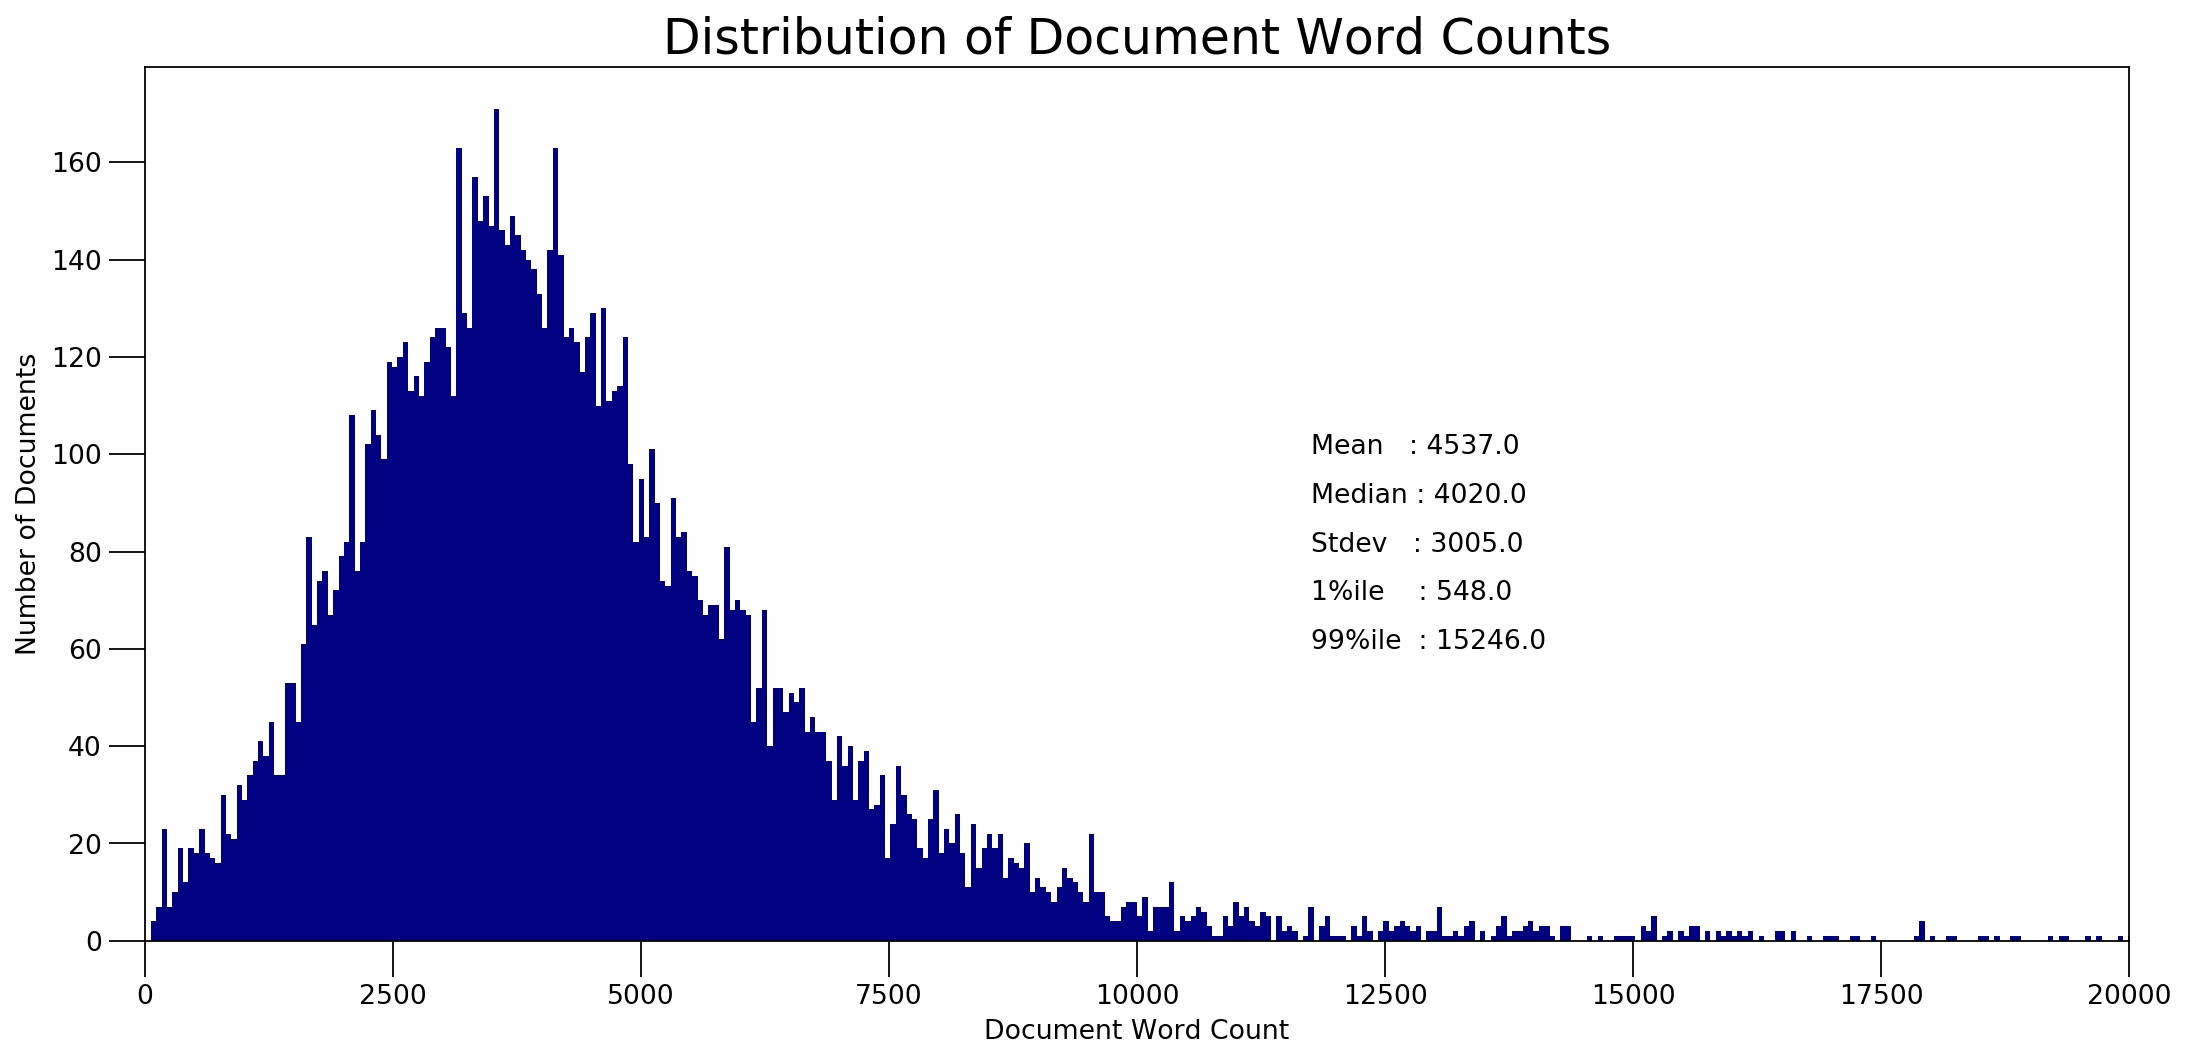

In [31]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(11750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(11750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(11750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(11750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(11750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,20000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

- Lets use wordclouds to check the most prominent words in each topic.

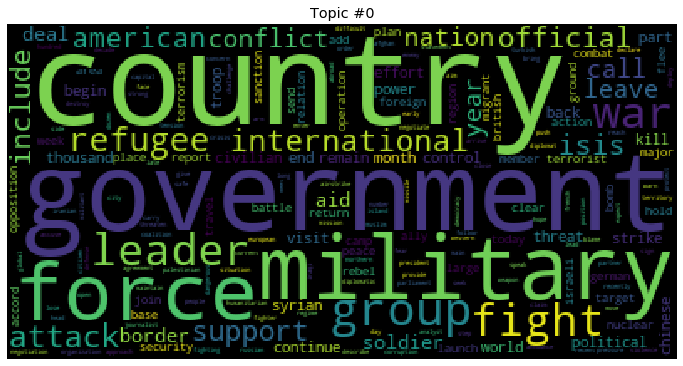

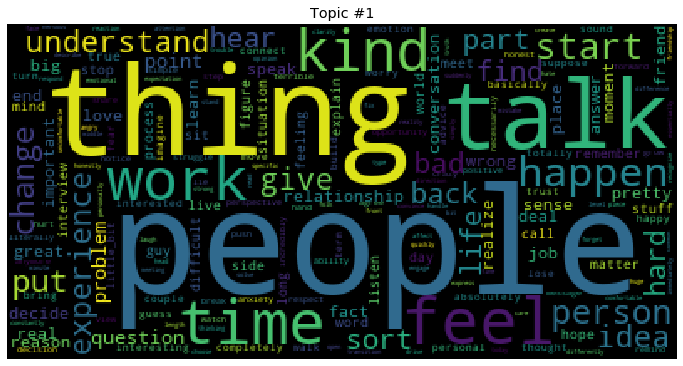

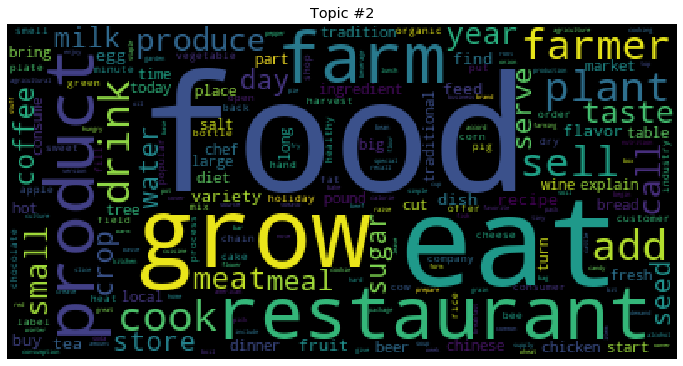

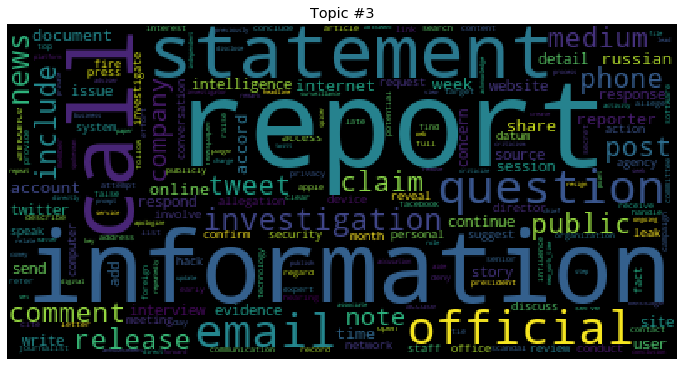

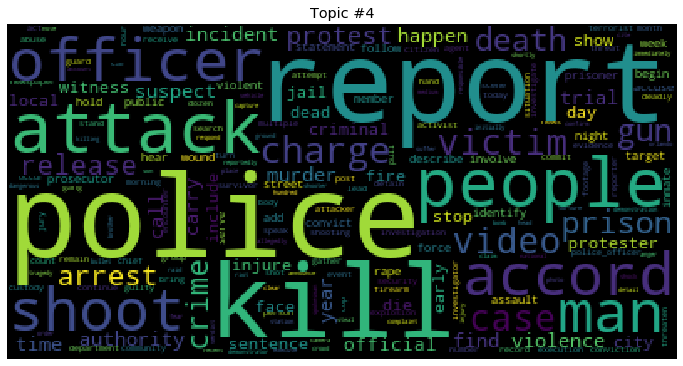

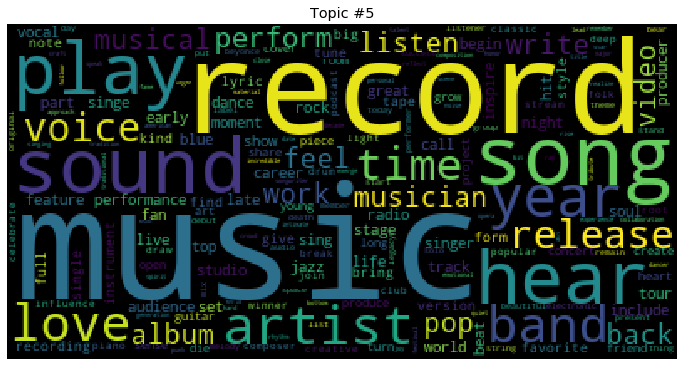

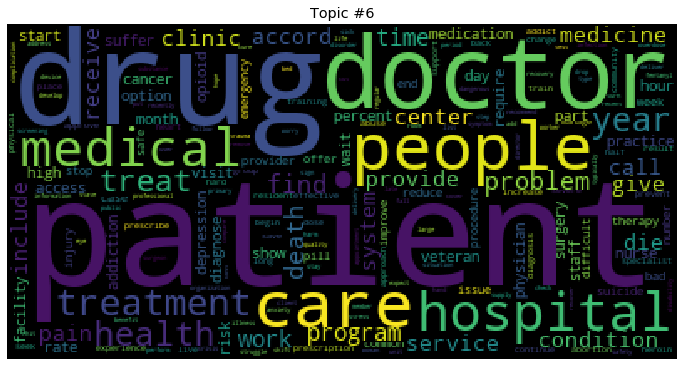

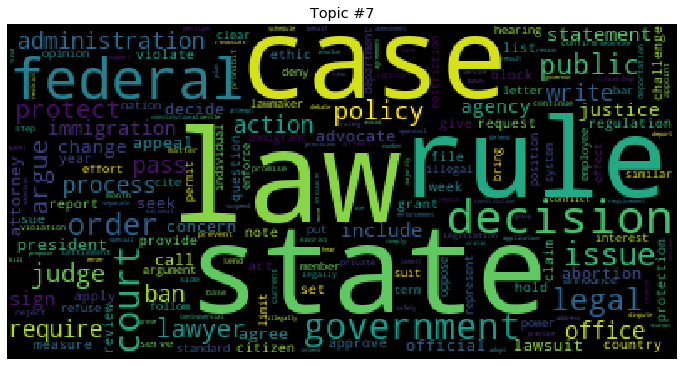

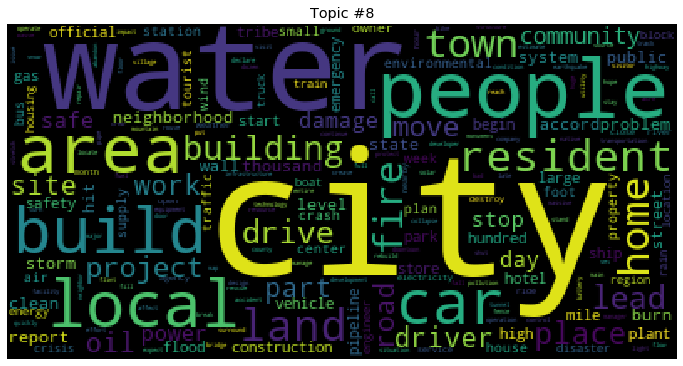

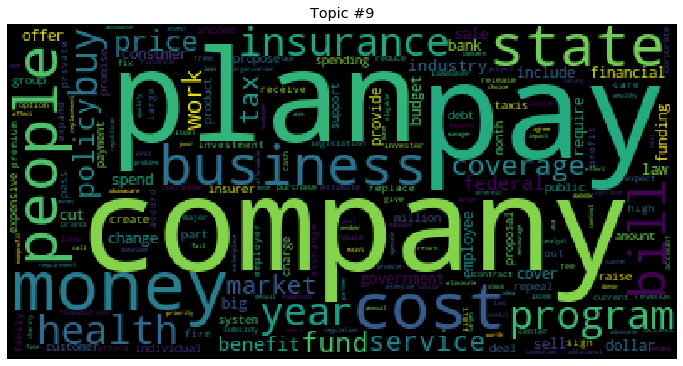

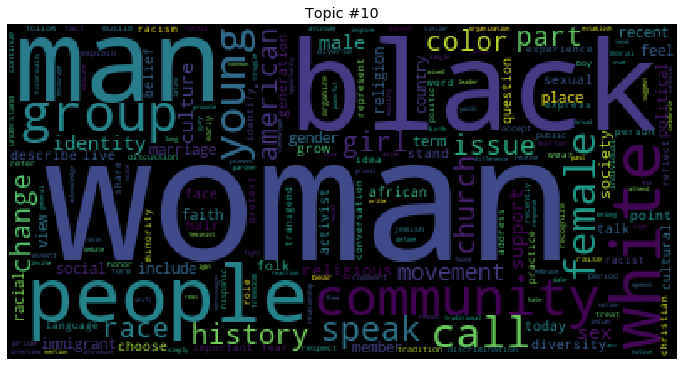

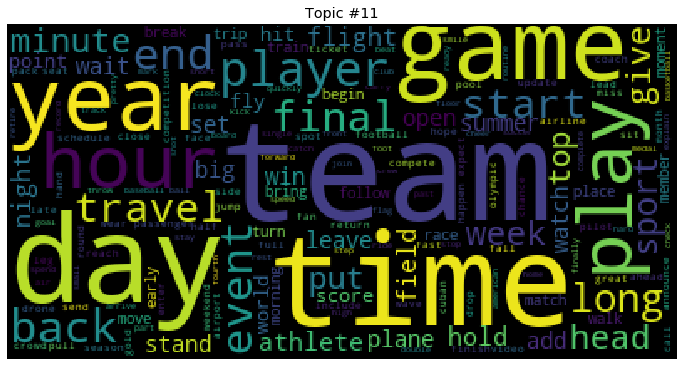

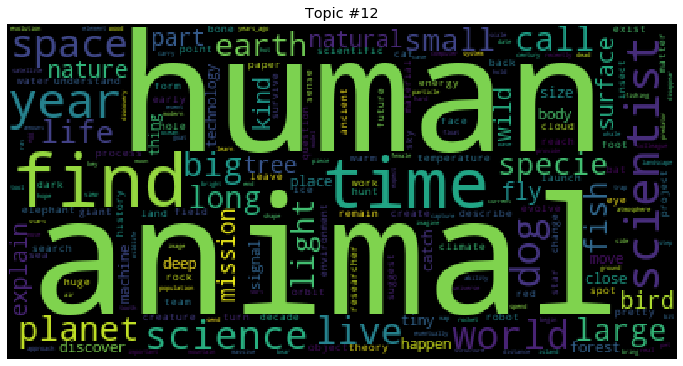

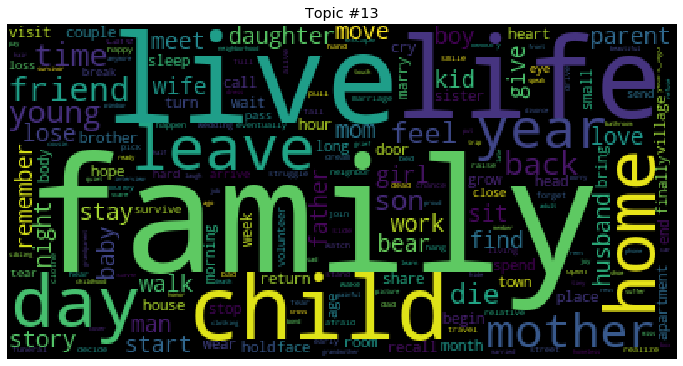

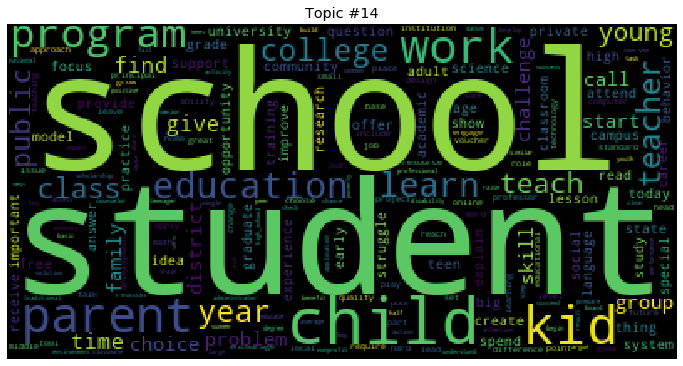

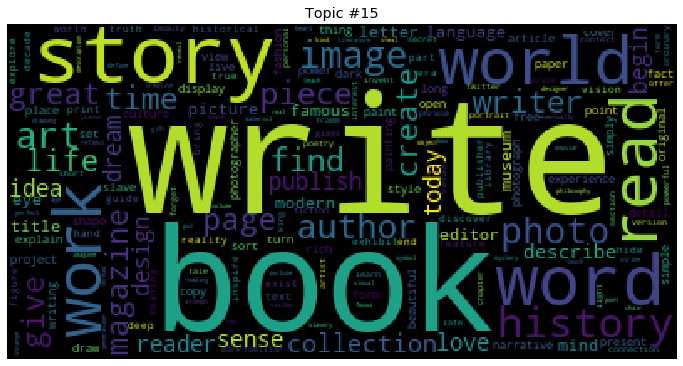

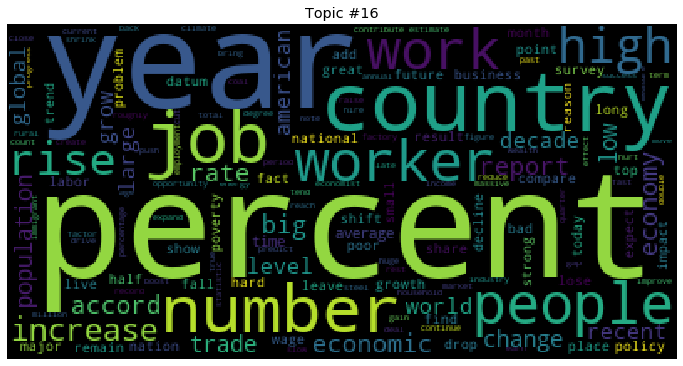

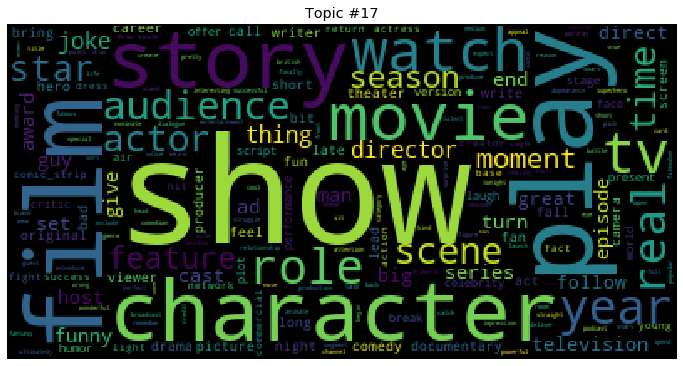

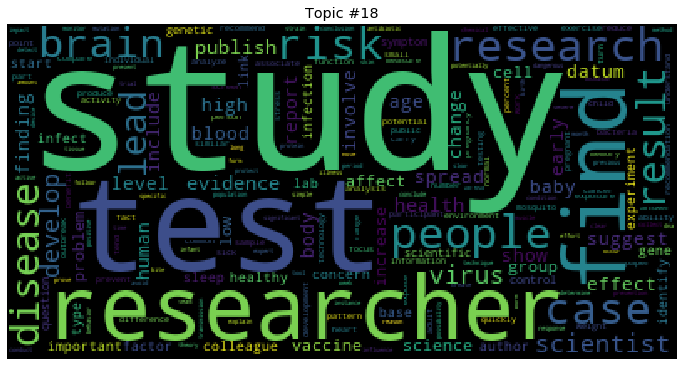

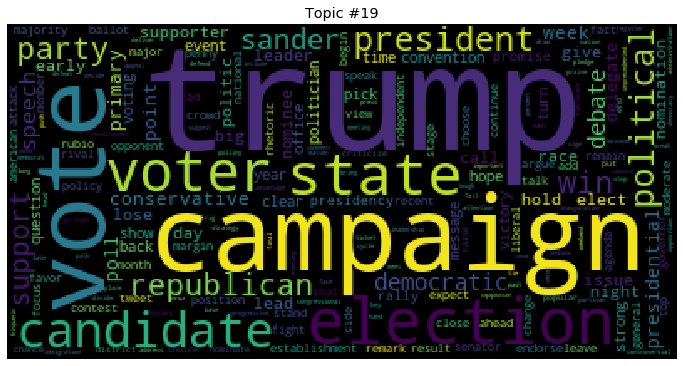

In [32]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

for t in range(optimal_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(optimal_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

- Finally,we create a dataframe to understand the volume and distribution of topics and also the top keywords under each topic.

In [33]:
## Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"country, government, military, force, group, w...",817,0.0681
1.0,1.0,"people, thing, talk, feel, time, work, kind, h...",318,0.0265
2.0,2.0,"food, eat, grow, restaurant, farm, product, fa...",639,0.0533
3.0,3.0,"report, information, call, statement, question...",717,0.0598
4.0,4.0,"police, report, kill, attack, people, officer,...",790,0.0659
5.0,5.0,"music, record, song, sound, hear, play, year, ...",859,0.0716
6.0,6.0,"patient, drug, doctor, people, care, hospital,...",439,0.0366
7.0,7.0,"law, state, case, rule, federal, decision, gov...",633,0.0528
8.0,8.0,"city, water, people, area, local, build, car, ...",581,0.0484
9.0,9.0,"pay, company, plan, money, cost, people, state...",606,0.0505


## Conclusion
- We started by building a topic model using Gensim's LDA and visualised the topics with pyLDAvis.
- Then we built a mallet's LDA and found the optimal number of topics using coherence scores.
- Finally we saw how to aggregate and and generate results that are more actionable and give great understanding on the 12000 articles! 